### Dacon AI프렌즈 시즌1 온도 추정 경진대회(1등 코드 리뷰+개인추가)
- https://dacon.io/competitions/official/235584/codeshare/1047?page=1&dtype=recent&ptype=pub // 1등 코드 리뷰
- https://dacon.io/competitions/official/235584/talkboard/400508?page=2&dtype=recent&ptype=pub // 사용 이미지 출처

## 1. 배경

- 우리나라에는 전국에 걸쳐 시도별 기상관측소가 있어 지역별 기온을 알 수 있습니다. 각 지역 내에서도 대상과 위치에 따라 온도 차이가 많이 납니다. 여름날 뜨거운 아스팔트 위를 걸어보셨거나, 겨울철 칼바람 부는 교량위를 걸어보신 분들은 체감하셨을 겁니다. 그렇다고 '모든 곳'에 관측소를 만들어 '지속적'으로 측정하기는 어렵습니다.

- 그래서 생각해 낸 방법이 ‘기상청 공공데이터를 활용한 온도추정’ 입니다. 저가의 센서로 관심대상의 온도를 단기간 측정하여 기상청의 관측 데이터와의 상관관계 모델을 만들고, 이후엔 생성된 모델을 통해 온도를 추정하여 서비스하는 것입니다. 2013년 10월부터 시행된 ‘공공데이터의 제공 및 이용에 관한 법률 제 21조’ 에 의해 기상청에서 데이터를 무료로 제공하고 있습니다. 멋지지 않나요? 새로운 알고리즘을 통해 'MY 기상청'을 만들어주세요.

## 데이터 설명
-     대전지역에서 측정한 실내외 19곳의 센서데이터와, 주변 지역의 기상청 공공데이터를 semi-비식별화하여 제공
-     센서는 온도를 측정
-     **모든 데이터는 시간 순으로 정렬 되어 있으며 10분 단위 데이터** .
-     **예측 대상(target variable)은 Y18**

### train.csv 
- **30일 간의 기상청 데이터 (X00-X39) 및 센서데이터 (Y00-Y17)**
- 이후 **3일 간의 기상청 데이터 (X00~X39) 및 센서데이터 (Y18)**
- 센서데이터 - 실내외 19곳

- 30일간은 Y0 ~ Y17 측정 O / Y18 - 측정X
- 30일 지난 3일간은 Y0 ~ Y17 측정 X / Y18 - 측정 O
- Y18은 정말 정확하게 측정하기가 힘들 것임. (3일 밖에 없으니까)
### test.csv 
-     train.csv 기간 이후 80일 간의 기상청 데이터 (X00~X39)

### 추가 데이터 설명
- https://dacon.io/competitions/official/235584/codeshare/737?page=1&dtype=recent&ptype=pub // 추가설명 잘나와있음.

- Dacon 답변 중 : 말씀하신 것처럼 5개의 변수는 각각 5개 지역의 기상청 관측 데이터를 의미합니다. 
- A지역: X00 / B지역: X07 / C지역: X28 / D지역: X31 / E지역: X32
- temperature_name = ["X00","X07","X28","X31","X32"] #기온
- localpress_name  = ["X01","X06","X22","X27","X29"] #현지기압
- speed_name       = ["X02","X03","X18","X24","X26"] #풍속
- water_name       = ["X04","X10","X21","X36","X39"] #일일 누적강수량
- press_name       = ["X05","X08","X09","X23","X33"] #해면기압
- sun_name         = ["X11","X14","X16","X19","X34"] #일일 누적일사량
- humidity_name    = ["X12","X20","X30","X37","X38"] #습도
- direction_name   = ["X13","X15","X17","X25","X35"] #풍향

### 시간
- 1일 = 24시간 = 1440분 = 144 행
- 3일 = 72시간 = 4320분 = 432 행
- 30일 = 720시간 = 43200분 = 4320 행
- train = 33일 = 792시간 = 47520분 = 4752 행 

### 1. 라이브러리 및 데이터

In [6]:
# Fundamentals
import os
import sys
import numpy as np
import pandas as pd
np.random.seed(55)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

# Machine Learning Algorithms
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Multiprocessing
from multiprocessing.dummy import Pool as ThreadPool

# 한글 나오게
from matplotlib import rc 
rc('font', family='malgun gothic')
rc('axes', unicode_minus = False)

pd.set_option('display.max_columns', 1200)
np.set_printoptions(threshold = sys.maxsize)

In [7]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')
print('데이터 로딩완료')

데이터 로딩완료


In [8]:
print(train.shape)
train.head()

(4752, 60)


,id,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,Y00,Y01,Y02,Y03,Y04,Y05,Y06,Y07,Y08,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
0,0,9.7,988.8,1.2,0.6,0.0,1009.3,989.6,12.2,1009.9,1009.8,0.0,0.0,82.4,71.3,0.0,101.1,0.0,56.1,0.3,0.0,91.0,0.0,1002.5,1009.8,1.1,2.3,0.5,1008.7,12.3,1001.6,69.1,8.2,10.7,1010.1,0.0,256.4,0.0,77.2,62.6,0.0,12.5,11.5,11.0,20.0,20.0,10.5,10.0,10.5,10.0,7.0,7.5,7.0,9.0,10.0,9.5,9.0,8.0,9.0,NaN
1,1,9.3,988.9,1.7,1.9,0.0,1009.3,989.6,12.1,1010.0,1009.9,0.0,0.0,81.2,121.8,0.0,165.3,0.0,0.0,0.4,0.0,91.9,0.0,1002.5,1009.9,0.0,0.0,0.0,1008.7,12.1,1001.7,70.3,8.3,10.3,1010.1,0.0,215.4,0.0,77.3,63.5,0.0,12.5,11.0,11.0,20.0,20.0,10.0,9.5,10.0,9.5,6.5,7.5,7.0,8.5,10.0,9.5,9.0,7.5,9.0,NaN
2,2,9.4,989.0,1.1,2.3,0.0,1009.2,989.7,12.1,1010.1,1010.1,0.0,0.0,86.1,232.0,0.0,144.0,0.0,0.0,0.6,0.0,93.3,0.0,1002.4,1009.8,0.0,0.0,0.0,1008.6,12.1,1001.6,71.5,8.0,9.7,1010.0,0.0,235.2,0.0,77.3,63.9,0.0,12.0,11.0,11.0,19.5,19.5,10.0,9.0,10.0,9.0,6.5,7.5,6.5,8.0,9.5,9.5,8.5,7.5,8.5,NaN
3,3,9.4,988.9,1.5,0.7,0.0,1009.2,989.6,12.0,1010.0,1010.0,0.0,0.0,87.7,0.0,0.0,115.9,0.0,294.1,0.1,0.0,93.4,0.0,1002.4,1009.7,0.0,0.0,0.2,1008.7,12.1,1001.5,73.2,7.7,9.4,1010.1,0.0,214.0,0.0,77.5,64.5,0.0,12.0,11.0,11.0,19.5,19.5,9.5,9.0,9.5,9.0,6.0,7.0,6.0,8.0,9.5,9.0,8.5,7.5,8.5,NaN
4,4,9.2,988.9,0.8,1.7,0.0,1009.2,989.7,12.0,1010.1,1010.0,0.0,0.0,88.9,0.0,0.0,124.7,0.0,0.0,0.0,0.0,94.1,0.0,1002.4,1009.7,0.0,0.0,0.0,1008.7,12.0,1001.5,74.3,7.4,9.4,1010.1,0.0,174.9,0.0,78.0,65.0,0.0,12.0,10.5,10.5,19.0,19.5,9.5,8.5,9.5,8.5,6.0,7.0,6.0,7.5,9.5,9.0,8.5,7.5,8.5,NaN


In [9]:
print(test.shape)
test.head()

(11520, 41)


,id,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39
0,4752,18.7,987.4,1.5,1.3,0.0,1006.8,987.7,21.1,1007.5,1007.2,0.0,0.0,96.1,333.6,0.0,199.6,0.0,36.0,1.1,0.0,94.7,0.0,1000.3,1007.6,0.0,0.0,0.1,1006.0,23.2,999.5,91.4,17.5,19.2,1007.6,0.0,194.7,0.0,84.0,59.9,0.0
1,4753,18.8,987.4,1.1,1.2,0.0,1006.7,987.7,21.2,1007.5,1007.2,0.0,0.0,96.2,335.5,0.0,194.0,0.0,127.7,0.6,0.0,95.3,0.0,1000.2,1007.5,0.0,0.0,0.3,1005.9,23.1,999.4,91.6,17.4,19.1,1007.5,0.0,173.1,0.0,84.0,60.5,0.0
2,4754,19.0,987.4,1.3,1.2,0.0,1006.6,987.6,21.2,1007.4,1007.2,0.0,0.0,96.4,0.0,0.0,172.9,0.0,59.0,0.0,0.0,93.9,0.0,1000.1,1007.4,0.0,0.0,0.7,1005.9,23.1,999.3,92.0,17.2,19.0,1007.5,0.0,208.6,0.0,85.0,60.8,0.0
3,4755,18.7,987.4,2.3,0.8,0.0,1006.6,987.6,21.1,1007.4,1007.2,0.0,0.0,96.5,252.9,0.0,153.5,0.0,54.9,0.4,0.0,94.4,0.0,1000.1,1007.4,0.0,0.0,0.6,1005.8,22.8,999.3,93.0,17.2,18.8,1007.4,0.0,185.0,0.0,85.8,61.2,0.0
4,4756,18.4,987.4,1.1,0.7,0.0,1006.7,987.7,20.9,1007.5,1007.2,0.0,0.0,96.6,238.2,0.0,173.8,0.0,48.8,0.8,0.0,95.7,0.0,1000.2,1007.3,0.0,0.0,0.7,1005.9,22.8,999.2,92.3,17.4,18.9,1007.5,0.0,162.8,0.0,87.3,61.7,0.0


### train data
- id
- X00 ~ X39 
- Y00 ~ Y18

### test
- id
- X00 ~ X39

- => 아마 Y00~ Y18이 없을 때 X00 ~ X39 만으로 센서데이터를 예측해라
- => Y18 센서가 데이터가 부족한데 어떻게 하면 제한된 Y18 데이터로 좋은 모델을 만들수 있을 것인가

### 데이터셋 설명
![데이터셋설명](./imgs/데이터셋설명.PNG)

### 센서위치
![센서위치](./imgs/센서위치.PNG)

In [10]:
# 편리하고 직관적인 Visionaliztion을 위한 Indicator Dictionary
indicator_dict = {
    'temperature'   : ["X00","X07","X28","X31","X32"], #기온
    'localpressure' : ["X01","X06","X22","X27","X29"], #현지기압
    'windspeed'     : ["X02","X03","X18","X24","X26"], #풍속
    'precipitation' : ["X04","X10","X21","X36","X39"], #일일 누적강수량
    'atmpressure'   : ["X05","X08","X09","X23","X33"], #해면기압
    'insolation'    : ["X11","X34","X14","X16","X19"], #일일 누적일사량
    'humidity'      : ["X12","X20","X30","X37","X38"], #습도
    'winddirection' : ["X13","X15","X17","X25","X35"], #풍향
}

In [11]:
# 데이터 분리
# Training Data는 총 33일의 날씨 data인데, 이를 Y18 값이 null인 30일(Train1)과 Y18 값이 존재하는 3일(Train2)로 나눔.
# 그리고 각각을 기상청 데이터(X)와 센서 데이터(Y01-Y17 or Y18)로 나눔.
idx1 = train[train['Y18'].isnull()].index # 0 ~ 4319 까지의 데이터 index Y18이 null 인것들
idx2 = train[~train['Y18'].isnull()].index # 4320 ~ 4751 까지의 데이터 index Y18이 null이 아닌것들

idx1, idx2

(Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
             ...
             4310, 4311, 4312, 4313, 4314, 4315, 4316, 4317, 4318, 4319],
            dtype='int64', length=4320),
 Int64Index([4320, 4321, 4322, 4323, 4324, 4325, 4326, 4327, 4328, 4329,
             ...
             4742, 4743, 4744, 4745, 4746, 4747, 4748, 4749, 4750, 4751],
            dtype='int64', length=432))

In [12]:
# Y18이 null인 경우를 기상청 데이터, 온도 데이터로 구분
train1_X = train[train.columns[:41]].loc[idx1].copy() # 기상청데이터
train1_Ys = train[train.columns[41:-1]].loc[idx1].copy() # 온도 데이터만 Y18은 뺴고

# Y18이 null 이 아닌경우를 기상청 데이터, 온도 데이터로 구분
train2_X = train[train.columns[:41]].loc[idx2].copy() # 기상청 데이터
train2_Y18 = train[train.columns[-1]].loc[idx2].copy() # 온도 데이터 Y18만

# test data (기상청 데이터만 있으니까 train과 같이 사용)
test_X = test.copy()

print(train1_X.shape, train1_Ys.shape, train2_X.shape, train2_Y18.shape, test_X.shape)

(4320, 41) (4320, 18) (432, 41) (432,) (11520, 41)


In [13]:
# train1, train2, test 합쳐서 데이터 훈련
combined_X = pd.concat([train1_X, train2_X, test_X], axis=0)
print(combined_X.shape)

# X_list 만든건 3Dataframe 을 다 처리할려고 
X_list = [train1_X, train2_X, test_X]

(16272, 41)


## 중간정리
- train1_X => Y18이 null이고 기상청 데이터 (0~4319행)
- train1_Ys => Y18이 null이고 온도 센서 데이터 Y18빼고 (0~4319행)
- train2_X => Y18이 null이 아니고 기상청 데이터 (4320~4751행)
- train2_Y18 => Y18이 null이 아니고 온도 센서 데이터 Y18만 (4320~4751행)

## 2. 데이터 분리 & EDA
#### 1) Check Missing Values (NULL 값들 체크)

In [14]:
# Check Missing Values
# 다 찢었으니까 당연히 null 인 것들은 없음
print(combined_X.isnull().sum().sum())
print(train1_X.isnull().sum().sum())
print(train1_Ys.isnull().sum().sum())
print(train2_X.isnull().sum().sum())
print(train2_Y18.isnull().sum())

0
0
0
0
0


#### 2) Check Anomalies (이상치 제거)

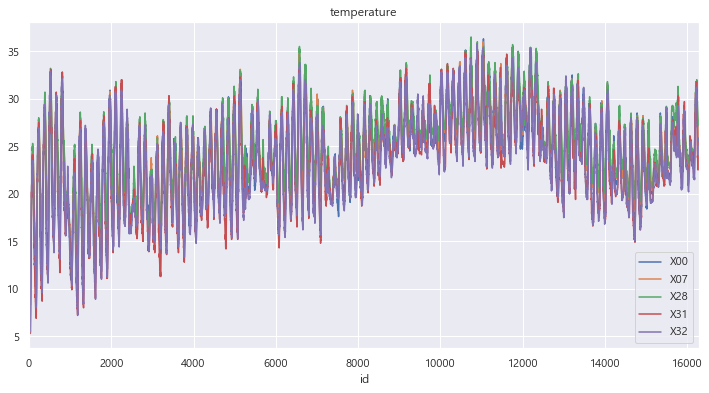

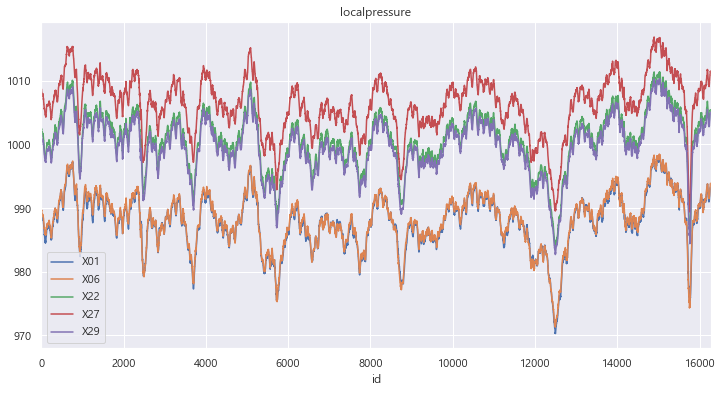

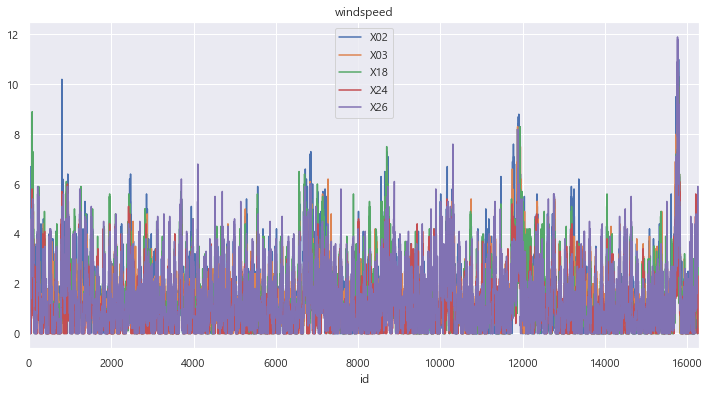

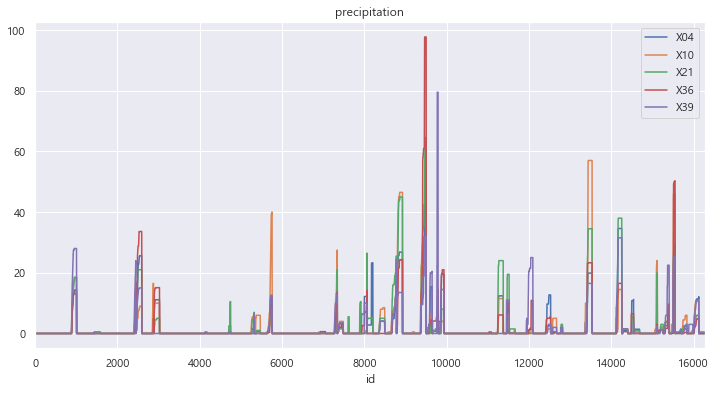

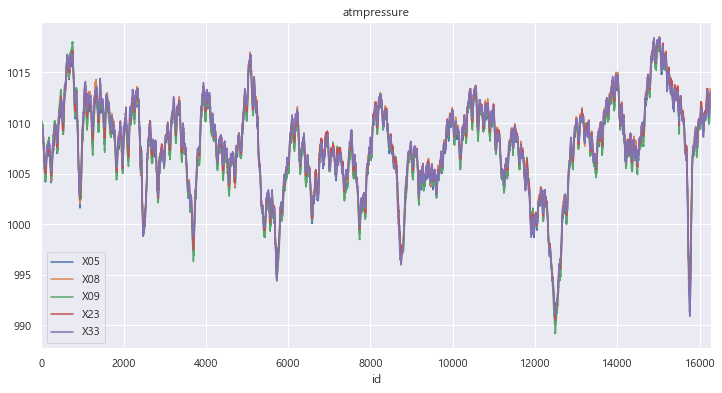

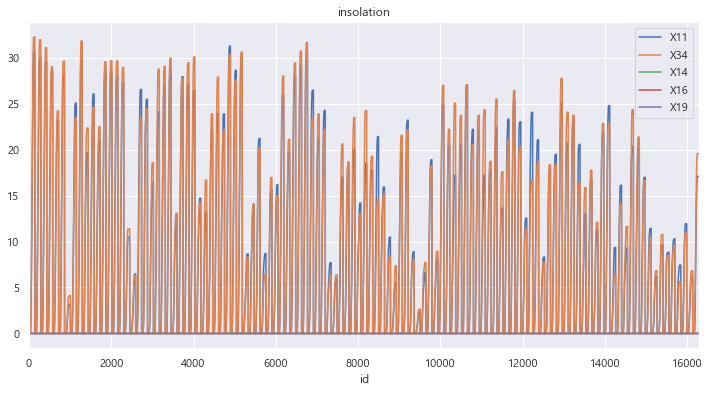

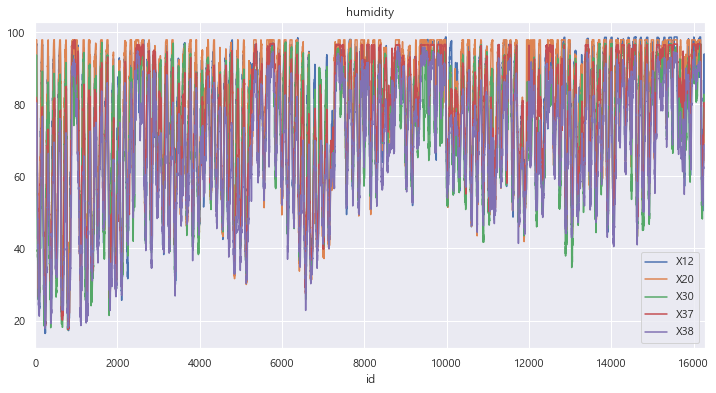

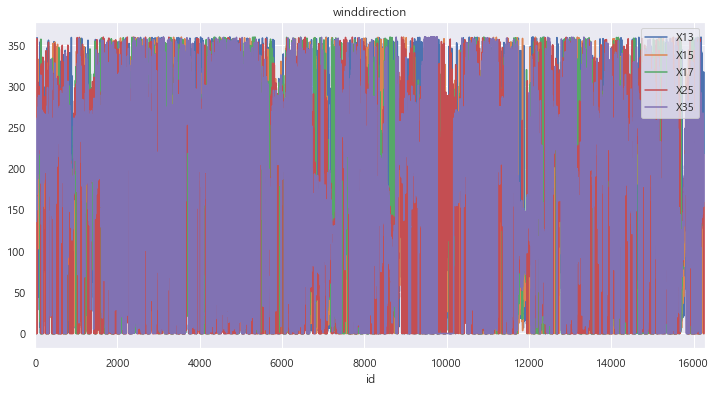

In [15]:
### indicator_dict 지표들 이상치 확인
# temperature - 기온
# localpressure - 현지기압
# windwpeed - 풍속
# precipitation - 일일 누적강수량
# atmpressure - 해면기압
# insolation - 일일누적일사량
# humidity - 습도
# winddirection - 풍향

# dictionary 문법, key, value 각각 k , v
for k, v in indicator_dict.items():
    combined_X.reset_index().plot(x='id', y=v, figsize=(12, 6))
    plt.gca().set_title(k) # gca는 현재 그림에 그려라

In [16]:
# 이상치 결론 및 Drop
# isolation - x14, x16, x19 가 0인것을 발견
pd.set_option('display.max_colwidth',-1)

# x14, x16, x19가 0인 것을 발견가능 -> 전처리서 drop
train1_X.describe()

,id,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39
count,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.0,4320.000000,4320.0,4320.000000,4320.000000,4320.0,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000
mean,2159.500000,19.965602,988.843935,1.544907,1.450625,1.397245,1008.562685,989.243148,21.437014,1009.048843,1008.649097,1.092477,11.035444,67.760764,161.079282,0.0,170.106181,0.0,157.252407,1.384213,0.0,71.275764,1.193403,1001.996782,1009.087037,0.979769,136.287870,1.361644,1007.795370,21.898565,1001.042315,65.251944,19.603796,19.750347,1009.313542,11.570391,207.183426,1.687199,65.374120,57.603773,1.185301
std,1247.220911,4.745137,3.427774,1.089174,0.955572,4.626973,3.456999,3.461409,4.423139,3.565190,3.598186,3.470172,10.966458,22.665787,97.954458,0.0,96.093590,0.0,114.066384,1.163265,0.0,22.308794,4.221925,3.433433,3.474953,1.099366,129.878643,1.262576,3.506099,4.275935,3.452114,22.020403,5.612736,5.345214,3.500218,11.463402,97.634867,5.828792,19.949689,18.695107,4.830633
min,0.000000,8.300000,977.300000,0.000000,0.000000,0.000000,997.200000,978.100000,11.600000,997.300000,996.300000,0.000000,0.000000,16.400000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,19.700000,0.000000,990.800000,997.500000,0.000000,0.000000,0.000000,997.200000,10.300000,989.700000,17.400000,5.300000,5.500000,998.700000,0.000000,0.000000,0.000000,17.500000,17.900000,0.000000
25%,1079.750000,16.500000,987.000000,0.800000,0.800000,0.000000,1006.700000,987.300000,18.100000,1007.000000,1006.700000,0.000000,0.017500,48.200000,70.800000,0.0,114.350000,0.0,30.075000,0.500000,0.0,52.400000,0.000000,1000.100000,1007.200000,0.000000,0.000000,0.300000,1005.900000,18.700000,999.200000,46.375000,15.700000,16.000000,1007.400000,0.030000,156.000000,0.000000,50.600000,42.900000,0.000000
50%,2159.500000,19.500000,989.000000,1.300000,1.300000,0.000000,1008.800000,989.500000,20.900000,1009.300000,1008.900000,0.000000,7.550000,71.500000,181.300000,0.0,160.900000,0.0,183.400000,1.000000,0.0,74.450000,0.000000,1002.300000,1009.400000,0.700000,124.650000,1.000000,1008.000000,21.600000,1001.300000,68.850000,19.100000,19.200000,1009.600000,8.015000,238.800000,0.000000,66.700000,58.700000,0.000000
75%,3239.250000,23.800000,991.300000,2.200000,2.000000,0.000000,1011.100000,991.800000,24.600000,1011.625000,1011.200000,0.000000,22.275000,89.100000,228.400000,0.0,253.025000,0.0,245.100000,2.100000,0.0,93.100000,0.000000,1004.500000,1011.600000,1.700000,268.000000,2.100000,1010.400000,25.000000,1003.500000,85.800000,23.900000,23.900000,1011.900000,22.902500,272.925000,0.000000,81.600000,71.900000,0.000000
max,4319.000000,30.900000,997.200000,10.200000,5.800000,25.600000,1016.800000,997.400000,32.700000,1017.500000,1018.000000,18.500000,30.700000,97.900000,359.900000,0.0,359.900000,0.0,359.600000,8.900000,0.0,97.900000,21.000000,1010.100000,1017.100000,6.000000,359.900000,6.800000,1015.400000,33.200000,1009.000000,97.200000,33.100000,32.900000,1016.800000,32.240000,359.900000,33.600000,97.800000,94.800000,28.000000


In [17]:
# Insolation 에서 X14, X16, X19 는 관측지가 없음. => Drop!
for X in X_list + [combined_X]:
    X.drop(['X14', 'X16', 'X19'], axis=1, inplace=True)
    
# 해당 dict 수정
indicator_dict['insolation'] = ["X11","X34"]

### 3) Time Series data의 특성을 활용해 date와 time 변수를 생성. (Feature Engineering을 위함)
- 날짜가 지나면서 축적된 데이터니까 / 행에 date가 없어서 임의로 생성해주는 것

#### 시간
- 1일 = 24시간 = 1440분 = 144 행
- 3일 = 72시간 = 4320분 = 432 행
- 30일 = 720시간 = 43200분 = 4320 행
- train = 33일 = 792시간 = 47520분 = 4752 행 
- test = 80일 = 1920시간 = 115200분 = 11520행

In [18]:
# 훈련데이터랑 테스트 데이터랑 합친 것
# 원래 4320행 / 432행 / 11520 

# combined_X = train1_X, train2_X, test_X (4320 + 432 + 11520) ==>
for X in X_list + [combined_X]:
    # X.index => 0 ~ 16272
    X['date'] = X.index // 144 ## 145번쨰 행은 1일이 될꺼
    X['time'] = X.index % 144 ## time 은 하루 1440분 
# X.index 말고 ? X.id? 가 맞을듯?
print(X.shape)
X
# 300행은 2일째가 될것 120분째 2일 2시정도 / 단 train1_X, train2_X, test_X 각각

(16272, 40)


,id,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X15,X17,X18,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,date,time
0,0,9.7,988.8,1.2,0.6,0.0,1009.3,989.6,12.2,1009.9,1009.8,0.0,0.0,82.4,71.3,101.1,56.1,0.3,91.0,0.0,1002.5,1009.8,1.1,2.3,0.5,1008.7,12.3,1001.6,69.1,8.2,10.7,1010.1,0.00,256.4,0.0,77.2,62.6,0.0,0,0
1,1,9.3,988.9,1.7,1.9,0.0,1009.3,989.6,12.1,1010.0,1009.9,0.0,0.0,81.2,121.8,165.3,0.0,0.4,91.9,0.0,1002.5,1009.9,0.0,0.0,0.0,1008.7,12.1,1001.7,70.3,8.3,10.3,1010.1,0.00,215.4,0.0,77.3,63.5,0.0,0,1
2,2,9.4,989.0,1.1,2.3,0.0,1009.2,989.7,12.1,1010.1,1010.1,0.0,0.0,86.1,232.0,144.0,0.0,0.6,93.3,0.0,1002.4,1009.8,0.0,0.0,0.0,1008.6,12.1,1001.6,71.5,8.0,9.7,1010.0,0.00,235.2,0.0,77.3,63.9,0.0,0,2
3,3,9.4,988.9,1.5,0.7,0.0,1009.2,989.6,12.0,1010.0,1010.0,0.0,0.0,87.7,0.0,115.9,294.1,0.1,93.4,0.0,1002.4,1009.7,0.0,0.0,0.2,1008.7,12.1,1001.5,73.2,7.7,9.4,1010.1,0.00,214.0,0.0,77.5,64.5,0.0,0,3
4,4,9.2,988.9,0.8,1.7,0.0,1009.2,989.7,12.0,1010.1,1010.0,0.0,0.0,88.9,0.0,124.7,0.0,0.0,94.1,0.0,1002.4,1009.7,0.0,0.0,0.0,1008.7,12.0,1001.5,74.3,7.4,9.4,1010.1,0.00,174.9,0.0,78.0,65.0,0.0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11515,16267,25.7,993.2,3.9,3.8,0.0,1011.7,993.8,26.3,1013.3,1012.6,0.0,17.1,88.1,65.6,101.6,176.7,1.8,77.3,0.0,1005.2,1012.9,1.6,169.8,4.5,1011.5,27.7,1004.9,76.6,23.6,24.4,1013.0,19.56,169.6,0.0,79.7,67.5,0.5,79,139
11516,16268,25.6,993.2,3.0,3.0,0.0,1011.7,993.8,26.3,1013.3,1012.6,0.0,17.1,75.5,51.9,84.8,187.8,2.9,78.1,0.0,1005.2,1012.9,1.9,138.9,4.7,1011.4,27.6,1004.9,76.7,25.3,24.4,1012.9,19.56,175.9,0.0,79.6,67.9,0.5,79,140
11517,16269,25.6,993.2,3.8,2.5,0.0,1011.9,993.7,26.2,1013.2,1012.7,0.0,17.1,77.5,29.0,104.5,184.8,2.9,78.9,0.0,1005.4,1013.0,2.3,146.7,4.8,1011.4,27.5,1005.0,77.1,24.9,24.3,1012.9,19.56,204.7,0.0,79.2,68.3,0.5,79,141
11518,16270,25.5,993.2,2.4,2.8,0.0,1011.8,993.7,26.1,1013.2,1012.6,0.0,17.1,74.1,30.0,103.0,187.8,3.4,79.7,0.0,1005.3,1013.0,1.7,146.5,3.5,1011.4,27.3,1005.0,77.3,25.3,24.2,1012.9,19.56,174.2,0.0,80.1,68.8,0.5,79,142


### 4) Modify Insolations and Precipitations
- 누적치 관련 처리 
- 일사량 (X11, X34),
- 강수량 (X04, X10, X21, X36, X39)

In [19]:
print(indicator_dict['insolation']) # 일일 누적 일사량 변수
print(indicator_dict['precipitation']) # 일일 누적강수량 변수

['X11', 'X34']
['X04', 'X10', 'X21', 'X36', 'X39']


In [20]:
# 일일 누적치는 실시간 온도 추정에서 설명력이 없으므로 정해진 시간 동안의 Insolation & Precipitation을 구함.

#### Modify the insolation (1) 일사량 (1시간) : 원래 값에서 1시간 이전(periods=6) -> 10분 * 6 = 1시간 의 값을 뺀 것으로 대치. 
# 일사량은 일자가 바뀌는 자정 부근에 0이므로, shift로 인한 null 값은 0으로 fill.
# 각각 0~4320, 0~432, 0~11520

for X in X_list: # X는 각각의 train1, train2, test
    dates = X['date'].unique() # date -> 0~29 / 30~32 / 0~79
    #print(dates)
    for d in dates:
        # train1_X 0~143 -> 144~287 -> 288~441 등 144씩 하루씩 30일 ~4752
        # train2_X 0~143 -> 144~287 -> 288~441 3일 ~442
        # test_X 0~143 -> 80일 ~ 11520
        day_idx = X.loc[X['date'] == d].index 
        
        #print('day_idx',day_idx)
        for f in indicator_dict['insolation']:
            #print(X.loc[day_idx, f])
            X.loc[day_idx, f] = X.loc[day_idx, f] - X.loc[day_idx, f].shift(periods=6).fillna(0) #null값은 0으로 대치
            
#### 쉽게 말해서 일단위로 144개씩 묶어서 빼기. -> 전체 한달, 3일, 80일 진행 shift함수 이용
print('일일 누적 일사량 변환 완료')

일일 누적 일사량 변환 완료


In [21]:
train1_X.head(150)

,id,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X15,X17,X18,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,date,time
0,0,9.7,988.8,1.2,0.6,0.0,1009.3,989.6,12.2,1009.9,1009.8,0.0,0.0,82.4,71.3,101.1,56.1,0.3,91.0,0.0,1002.5,1009.8,1.1,2.3,0.5,1008.7,12.3,1001.6,69.1,8.2,10.7,1010.1,0.0,256.4,0.0,77.2,62.6,0.0,0,0
1,1,9.3,988.9,1.7,1.9,0.0,1009.3,989.6,12.1,1010.0,1009.9,0.0,0.0,81.2,121.8,165.3,0.0,0.4,91.9,0.0,1002.5,1009.9,0.0,0.0,0.0,1008.7,12.1,1001.7,70.3,8.3,10.3,1010.1,0.0,215.4,0.0,77.3,63.5,0.0,0,1
2,2,9.4,989.0,1.1,2.3,0.0,1009.2,989.7,12.1,1010.1,1010.1,0.0,0.0,86.1,232.0,144.0,0.0,0.6,93.3,0.0,1002.4,1009.8,0.0,0.0,0.0,1008.6,12.1,1001.6,71.5,8.0,9.7,1010.0,0.0,235.2,0.0,77.3,63.9,0.0,0,2
3,3,9.4,988.9,1.5,0.7,0.0,1009.2,989.6,12.0,1010.0,1010.0,0.0,0.0,87.7,0.0,115.9,294.1,0.1,93.4,0.0,1002.4,1009.7,0.0,0.0,0.2,1008.7,12.1,1001.5,73.2,7.7,9.4,1010.1,0.0,214.0,0.0,77.5,64.5,0.0,0,3
4,4,9.2,988.9,0.8,1.7,0.0,1009.2,989.7,12.0,1010.1,1010.0,0.0,0.0,88.9,0.0,124.7,0.0,0.0,94.1,0.0,1002.4,1009.7,0.0,0.0,0.0,1008.7,12.0,1001.5,74.3,7.4,9.4,1010.1,0.0,174.9,0.0,78.0,65.0,0.0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,145,12.3,986.9,1.6,0.6,0.0,1006.9,987.5,16.1,1007.4,1007.8,0.0,0.0,83.5,154.9,137.5,0.0,0.7,86.2,0.0,1000.2,1007.2,1.2,247.8,0.0,1006.0,16.2,999.1,52.3,10.6,15.5,1007.4,0.0,208.5,0.0,66.6,59.5,0.0,1,1
146,146,12.1,986.9,1.9,0.9,0.0,1006.8,987.4,15.9,1007.3,1007.8,0.0,0.0,84.9,0.0,152.0,0.0,0.1,87.2,0.0,1000.1,1007.2,0.6,260.2,0.0,1006.1,16.1,999.1,51.2,10.3,15.6,1007.5,0.0,236.1,0.0,67.5,59.5,0.0,1,2
147,147,12.1,986.8,1.4,0.5,0.0,1006.8,987.3,15.8,1007.2,1007.7,0.0,0.0,86.0,21.6,147.1,0.0,0.5,88.5,0.0,1000.1,1007.3,0.6,324.3,0.0,1006.2,16.0,999.2,52.2,10.0,15.3,1007.6,0.0,230.0,0.0,68.1,60.0,0.0,1,3
148,148,11.9,986.8,1.5,0.4,0.0,1006.8,987.2,15.7,1007.2,1007.7,0.0,0.0,85.7,245.3,191.3,24.4,0.4,88.6,0.0,1000.1,1007.3,0.0,0.0,0.7,1006.3,15.8,999.2,54.1,9.9,14.9,1007.7,0.0,253.1,0.0,69.0,60.3,0.0,1,4


In [22]:
train1_X['X04'].describe()

count    4320.000000
mean     1.397245   
std      4.626973   
min      0.000000   
25%      0.000000   
50%      0.000000   
75%      0.000000   
max      25.600000  
Name: X04, dtype: float64

In [23]:

# 결과적으로는 강수량 Feature는 쓰이지 않음.
#### Modify the Precipitation (2) 강수량 (6시간) : 원래 값에서 3시간 이전(periods=18)의 값을 뺀 것으로 대치. 
# 강수량은 시간대와 관계없이 나타나므로, 날짜가 바뀌는 날에 0으로 reset됨. => 하루 전날의 누적 강수량을 더하여 값을 구함.
for X in X_list:
    dates = X['date'].unique() # date -> 0~29 / 30~32 / 0~79
    for f in indicator_dict['precipitation']: # X04, X10, X21, X36, X39
        for d in dates[::-1]:
            day_idx = combined_X.loc[combined_X['date'] == d].index
            yes_day_idx = combined_X.loc[(combined_X['date'] == d-1)].index
            dl,yl = list(day_idx), list(yes_day_idx)
            dl.extend(yl)
            #print(set(dl))
            day_precip = combined_X.loc[set(dl), f]
            # 추가문장 - duplicate 오류 -;
            day_precip = day_precip.loc[~day_precip.index.duplicated(keep='first')]

            #day_precip = combined_X.loc[(set(yes_day_idx) or set(day_idx)), f]

            # 편의를 위해 Train1, Train2, Test set 각각의 첫날(d=0)의 하루 전 누적 강수량은 0으로 고정함.
            yesterday_cum_precip = day_precip.loc[yes_day_idx].max() if d != 0 else 0 
            day_precip.loc[day_idx] += yesterday_cum_precip
            day_precip_shift = day_precip.shift(periods=36).fillna(0)
            
            X.loc[day_idx, f] = day_precip.loc[day_idx] - day_precip_shift.loc[day_idx]
print('일일 강수량 누적 해결 완료')

일일 강수량 누적 해결 완료


In [24]:
'''shift 함수 연습'''
np.random.seed(0)
ts = pd.Series(np.random.randn(6), index=pd.date_range(
    "2018-5-1", periods=6, freq="d"))
ts

2018-05-01    1.764052
2018-05-02    0.400157
2018-05-03    0.978738
2018-05-04    2.240893
2018-05-05    1.867558
2018-05-06   -0.977278
Freq: D, dtype: float64

In [25]:
ts.shift(1)

2018-05-01   NaN      
2018-05-02    1.764052
2018-05-03    0.400157
2018-05-04    0.978738
2018-05-05    2.240893
2018-05-06    1.867558
Freq: D, dtype: float64

In [26]:
ts.shift(-1).fillna(0)

2018-05-01    0.400157
2018-05-02    0.978738
2018-05-03    2.240893
2018-05-04    1.867558
2018-05-05   -0.977278
2018-05-06    0.000000
Freq: D, dtype: float64

## 3. 탐색적 자료분석 - ys, y 값들 과 Feature들
### Exploratory Data Analysis + Feature Generation
#### 1) Train data에서 각 Feature의 평균값과 센서 데이터(Y01-Y17 or Y18)의 평균값과의 상관관계 분석

In [27]:
train1_Ys

,Y00,Y01,Y02,Y03,Y04,Y05,Y06,Y07,Y08,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17
0,12.5,11.5,11.0,20.0,20.0,10.5,10.0,10.5,10.0,7.0,7.5,7.0,9.0,10.0,9.5,9.0,8.0,9.0
1,12.5,11.0,11.0,20.0,20.0,10.0,9.5,10.0,9.5,6.5,7.5,7.0,8.5,10.0,9.5,9.0,7.5,9.0
2,12.0,11.0,11.0,19.5,19.5,10.0,9.0,10.0,9.0,6.5,7.5,6.5,8.0,9.5,9.5,8.5,7.5,8.5
3,12.0,11.0,11.0,19.5,19.5,9.5,9.0,9.5,9.0,6.0,7.0,6.0,8.0,9.5,9.0,8.5,7.5,8.5
4,12.0,10.5,10.5,19.0,19.5,9.5,8.5,9.5,8.5,6.0,7.0,6.0,7.5,9.5,9.0,8.5,7.5,8.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,22.0,22.5,22.5,26.0,26.0,21.0,20.0,20.5,20.5,19.5,20.0,19.0,20.5,20.5,20.0,20.0,20.5,20.0
4316,22.0,22.5,22.5,26.0,25.5,21.0,20.0,20.5,20.5,19.5,20.0,19.0,20.5,20.5,20.0,19.5,20.5,19.5
4317,21.5,22.5,22.5,26.0,25.5,21.0,20.0,20.5,20.5,19.5,20.0,19.0,20.0,20.0,19.5,19.5,20.0,19.0
4318,21.5,22.0,22.0,25.5,25.5,20.5,20.0,20.0,20.0,19.5,20.0,18.5,20.0,20.0,19.5,19.5,20.0,19.0


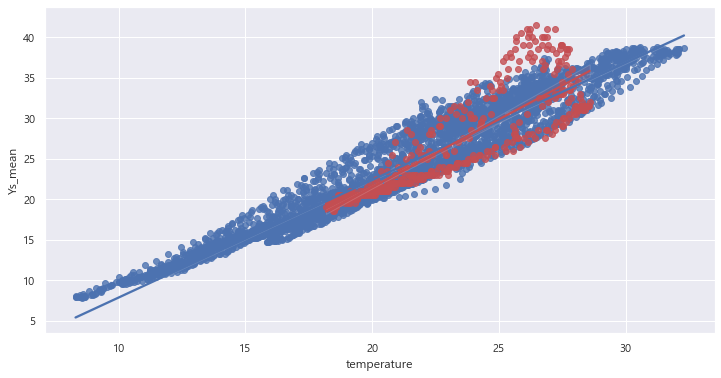

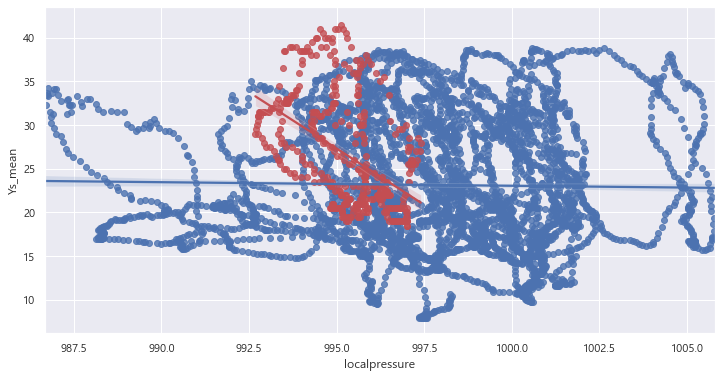

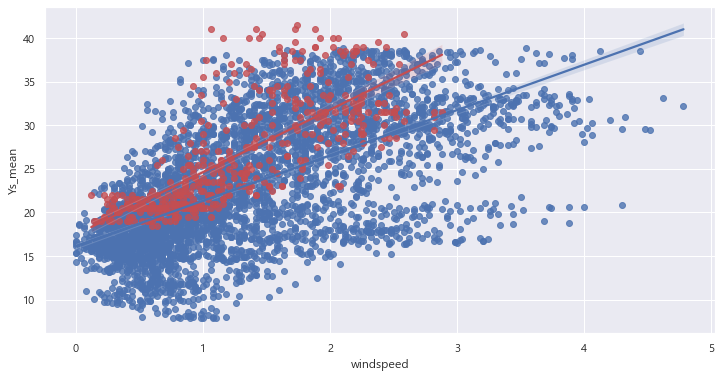

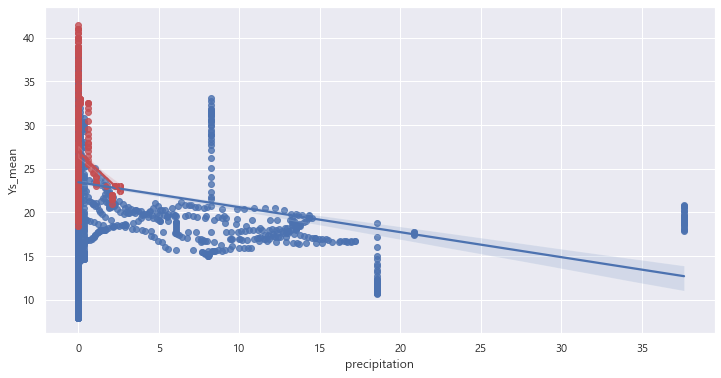

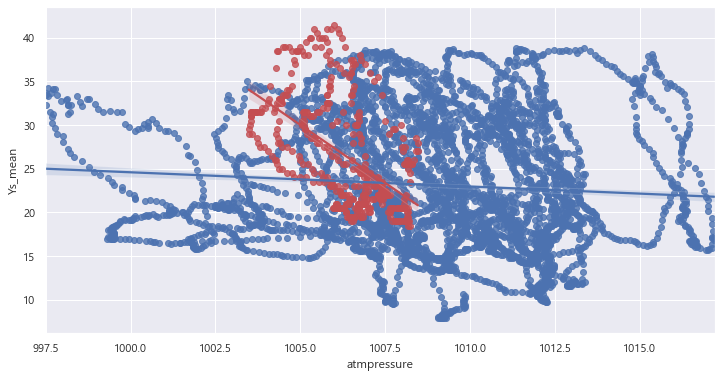

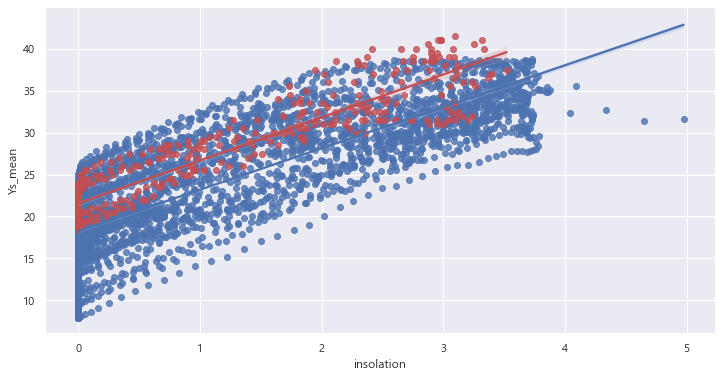

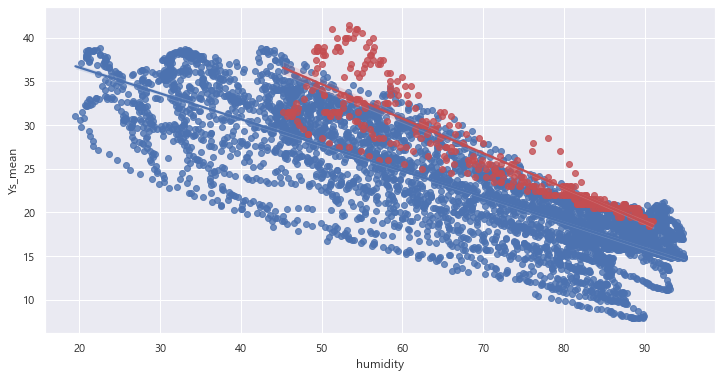

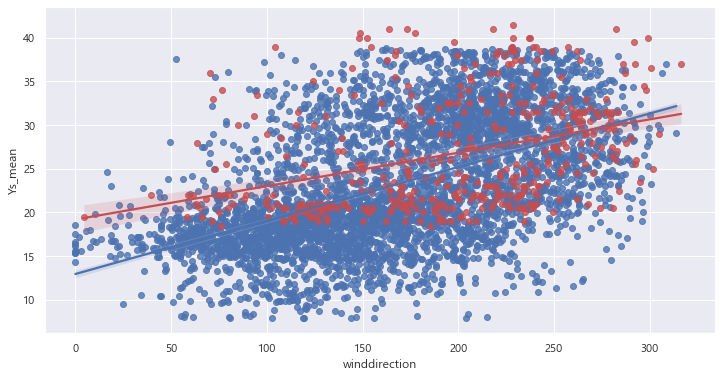

In [28]:
# 센서 데이터들의 평균과 기상 지표들과의 비교
# 특징변수들과 목적변수들의 상관관계를 본것.
train1_Ys_mean = train1_Ys.mean(axis=1) # 센서 데이터들 평균

# 기상 지표들
for k, v  in indicator_dict.items(): # 기상 지표들의 평균값과
    
    train1_feature_mean = train1_X[v].mean(axis=1)
    train2_feature_mean = train2_X[v].mean(axis=1)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.regplot(train1_feature_mean, train1_Ys_mean, ax=ax)
    sns.regplot(train2_feature_mean, train2_Y18, ax=ax, color='r')
    ax.set_xlabel(k)
    ax.set_ylabel('Ys_mean')

# 파란색 - Trian1
# 빨간색 - Train2

 ## => Train1 과 Train2 모두 완벽한 상관관계를 보인건 기온, 습도, 일사량 => 요것만 사용 하기로 함

In [29]:
# Training data가 부족하다는 Task의 특성상 Linear model이 적절하다고 판단함. 
# 따라서 Train1과 Train2에서 consistent하게 linear한 상관관계가 있는 temperature, humidity, insolation 외에는 모두 drop 하기로 함.

# temperature, humid, isolation 만 사용
for df in X_list:
    df.drop(indicator_dict['localpressure'], axis=1, inplace=True) # 
    df.drop(indicator_dict['atmpressure'], axis=1, inplace=True) # 대기압
    df.drop(indicator_dict['windspeed'], axis=1, inplace=True) # 풍속
    df.drop(indicator_dict['winddirection'], axis=1, inplace=True) # 풍향
    df.drop(indicator_dict['precipitation'], axis=1, inplace=True) # 강수량
indicator_dict = dict((k,indicator_dict[k]) for k in ['temperature', 'humidity', 'insolation'] if k in indicator_dict)

#### 회귀니까 상관관계로 보고, train_sample이 적으면 그 샘플들이 너무 과대적합되기 쉬우니까
#### 데이터 갯수가 적으니까 비선형 적인 것도 찾기 힘들고, 변수과의 관계만 봤을때도 나름 선형적인 모양을 보이기 때문.

#### 2) Train1에서 각 Feature의 variation 분석 (vs mean of Ys)

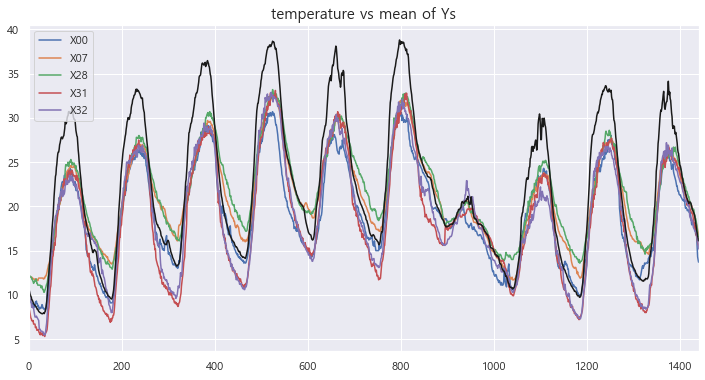

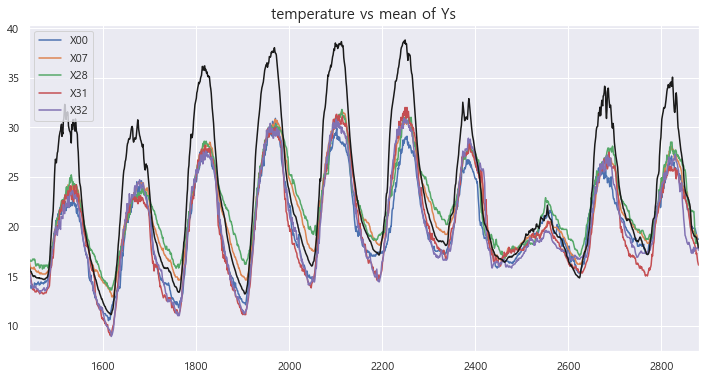

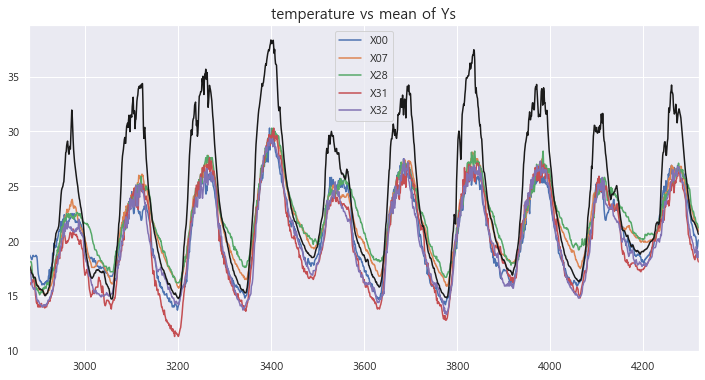

In [25]:
# 30일을 10일 단위로 나누어 visualization. 총 하나의 지표 그래프임 - temperature - Ysmean
# 전체 지역은 아마 대전 - 서로 위치만 조금식 다른것
# 시간의 흐름따라 본 것. ==> temperature가 거의 ys들과 선형적
# vs temperature
for idx in range(0, 30, 10):
    idx1, idx2 = 144*idx, 144*(idx+10)

    fig, ax = plt.subplots(figsize=(12, 6))
    train1_X.loc[idx1:idx2, indicator_dict['temperature']].plot(ax=ax) # 온도지표들
    train1_Ys_mean.loc[idx1:idx2].plot(ax=ax, color='k') # 센서 데이터들의 평균
    ax.set_title('temperature vs mean of Ys', size=15)

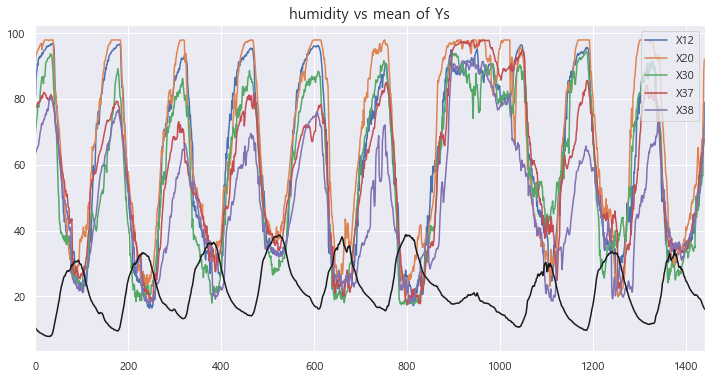

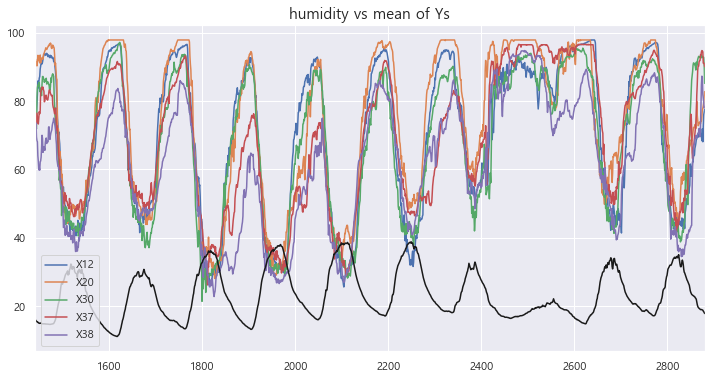

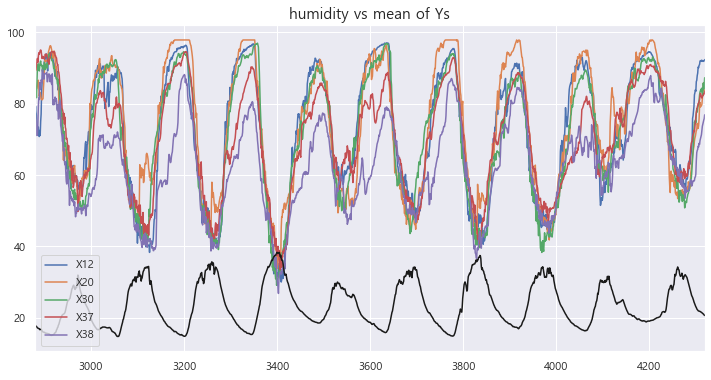

In [26]:
# vs humidity
for idx in range(0, 30, 10):
    idx1, idx2 = 144*idx, 144*(idx+10)

    fig, ax = plt.subplots(figsize=(12, 6))
    train1_X.loc[idx1:idx2, indicator_dict['humidity']].plot(ax=ax)
    train1_Ys_mean.loc[idx1:idx2].plot(ax=ax, color='k')
    ax.set_title('humidity vs mean of Ys', size=15)

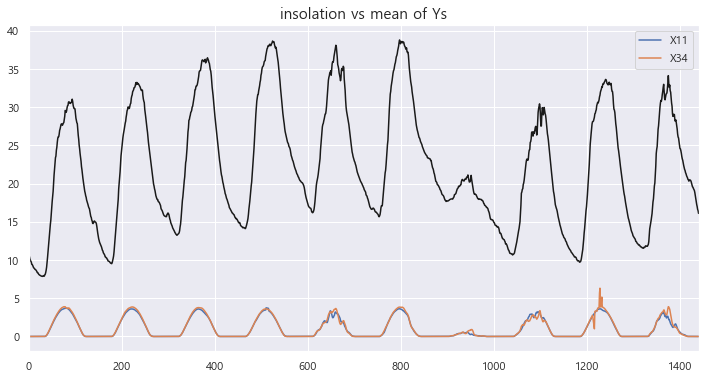

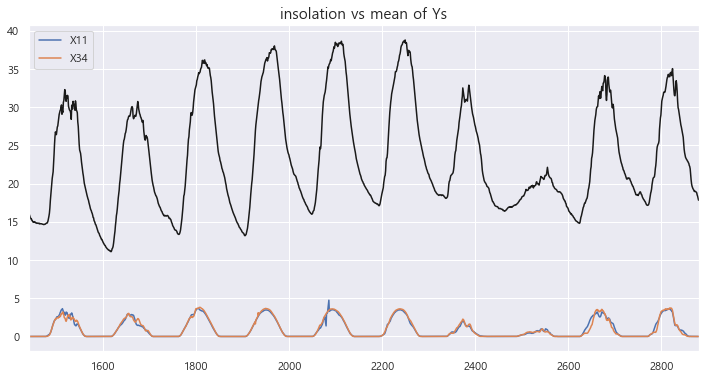

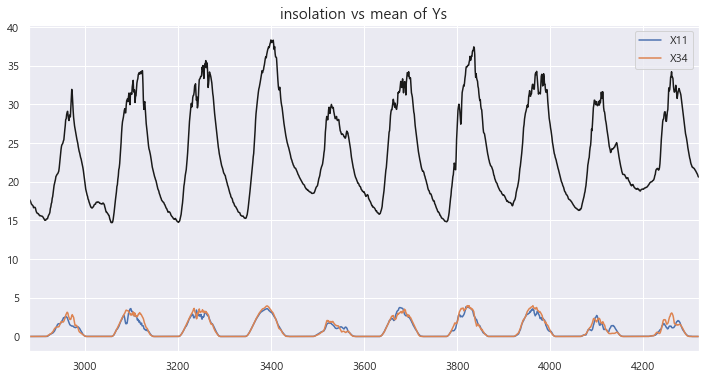

In [27]:
# vs insolation
for idx in range(0, 30, 10):
    idx1, idx2 = 144*idx, 144*(idx+10)

    fig, ax = plt.subplots(figsize=(12, 6))
    train1_X.loc[idx1:idx2, indicator_dict['insolation']].plot(ax=ax)
    train1_Ys_mean.loc[idx1:idx2].plot(ax=ax, color='k') # 센서들의 평균
    ax.set_title('insolation vs mean of Ys', size=15)

### 일반 다른 센서들과 Feature들을 통해 알 수 있는 결과
- **humidity는 음의 상관관계 / temperature, insolation은 같은 양의 상관관계**
- 변수들마다 약간의 variation이 있음을 알 수 있음. (변동, 차이)
- 이에 따라 temperature와 humidity 각각의 몇개의 변수들로 평균값을 만들었을 때 Public Score가 증가함. ==> temp_mean, hum_mean 생성 ==> 이 과정에서도 임의변수 제거. 단지 스코어를 높이기 위한. => 사실상 정말 대회 목적 / 스태킹도 이런느낌

In [28]:
# Genearte temp_mean and hum_mean
for X in X_list:
    X['temp_mean'] = X[["X07","X28","X31","X32"]].mean(1) # x00 제외 -> 특별이유x
    X['hum_mean'] = X[["X30","X37","X38"]].mean(1) # x12, x20을 제외 -> 특별이유x
indicator_dict['temperature'].append('temp_mean')
indicator_dict['humidity'].append('hum_mean')

#### Mean을 활용할 수 있는 이유 -> 그래프 적인 측면에서 보면 보라색과 맨위 회색과의 거리가 좀 있으니까,
#### 같은걸 측정하는데 지역별로 다르니까, 다섯 개의 선을 대표할 수 있는 그 평균적으로 봤다는 것
#### 즉 평균을 넣은것은 분산의 크기가 다르니까

#### 3) Train2의 각 Feature과 Y18 값의 분포 (Train1 - ys / Train2 - y18)

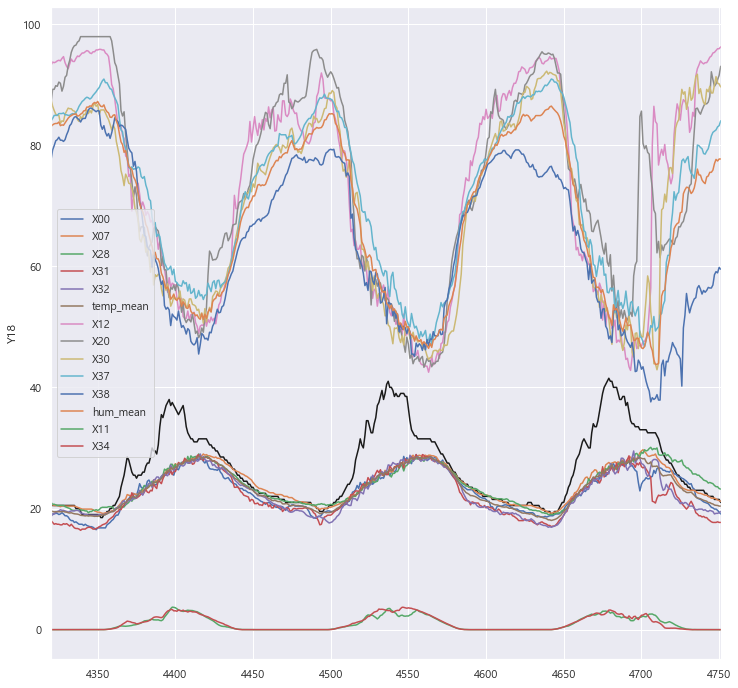

In [29]:
# Humidity vs Y18
fig, ax = plt.subplots(figsize=(12, 12))
sns.lineplot(x=train2_X.index, y=train2_Y18, ax=ax, c='k')
train2_X[indicator_dict['temperature']].plot(ax=ax)
train2_X[indicator_dict['humidity']].plot(ax=ax)
train2_X[indicator_dict['insolation']].plot(ax=ax)

# 맨 위에 그래프들이 습도 / 두번째가 temperature / 맨 아래가 insolation

- **센서들의 평균이 최고기온을 찍은뒤에 1시간 후에 기온이 급강하하는 모습을 보였**는데 (4400 바로 앞)
- **Y18 센서 관측소의 지리적 요인이라고 생각**하고, 그림자가 생겨서 그런것이다라고 생각하고, 일사량의 반대방향으로 작용하는 그림자 Feature라는 것을 만듬 
- ex) 건물이 가리고 있어서 해가 쨍쨍할때는 가린다고 그림자 기운다고 생각
- 그림자는 80이라는 시간부터 (오후 1시~) 89 정도에 완전히 드리워진 것으로 선택(딱한 이유 없음)


In [30]:
# Y18은 최고기온에 도달하고 약 1시간 정도 후에 기온이 급강하 하는 패턴을 보임.
# 이를 Y18 관측소의 지리적 요인에 의해 그림자가 생긴 것으로 가설을 세우고 neg_insol feature를 생성.

# effect of Shadow or something after about 1pm. 
for X in X_list:
    insol = X['X34']
    insol.index = X.index
    neg_insol = pd.Series(np.zeros_like(insol.values), index=X.index)

    # 그림자 지기 시작하는 시간 완전히 진 시간 임의로 정한 것. 
    time1_index = X.loc[X['time'] == 80].index  # 그림자가 지기 시작하는 시간
    time2_index = X.loc[X['time'] == 89].index  # 그림자가 완전히 진 시간
    end_index = X.loc[X['time'] == 143].index
    
    # 정규화 log를 적용 - 어느정도 부드럽게
    for t1, t2, end in zip(time1_index, time2_index, end_index):
        # 그림자가 만들어지기 시작하는 시간 - 그림자가 완전히 진 시간 까지 (어느정도 모형이 부드럽게 하기 위해서 log)
        # 일사량 값과 관계가 있으니까 쓴거고, 그림자가 지기 시작할때 
        neg_insol.loc[t1:t2-1] = insol.loc[t1:t2-1] * (np.logspace(-1, 0, (t2-t1))-0.1)
        
        # 그림자가 완전히 지고난 후에는 일사량 양과 그대로?
        neg_insol.loc[t2:end] = insol.loc[t2:end]
    
    # 해가 쨍쩅할때는 그림자가 Y18을 감소시켰지만, 저녁이 되거나 구름낀 날에는 그림자가 주는 영향이 줄어들어야 한다고 생각해서
    # 습도를 기준으로 습도가 높으면 (흐리거나 저녁이 되거나) 그림자영향력이감소하도록 하여 1-humidity_mean)을 곱함
    ## ex) 건물이 가리고 있다고 생각하고, 해가 쨍쨍하니까 건물이 그림자져서 가리는거임. 근데 흐리면은 그림자가 상관이 없으니까 그 영향력을 작게 해주려고 하는 것
    
    # 해가 질수록 (humidity가 상승할수록) neg insol의 영향력이 줄어들어야 한다고 판단하여 neg_insol에 mean of humidity를 곱해줌.
    humidity_mean = X[indicator_dict['humidity']].mean(1) / 100 
    X['neg_insol'] = neg_insol * (1-humidity_mean) #
    
indicator_dict['insolation'].append('neg_insol')

### (후술) 추가 변수 선택 및 제거
- Feature 수가 많지 않아 각 변수들을 하나씩 제거해가며 모델의 성능을 비교해 보았음.
- **Temperature의 X00, Insolation의 X11을 제거했을 때 Public Score가 증가함.**
- **public score가 높아졌다라는 (=해봤더니 좋다더라) 이에 대한 근거 => 아예 내가 그림자 변수를 만들고, 이런것들이 다 가설이라는 것. 그리고 public score가 좋다는 것은 그말이 어느정도 맞다는 증빙**
- +일부 변수들은 시간대별로 영향력이 달라 특정 시간대에서 변수를 제거했을 때 모델 성능이 증가했음. (후술)

In [31]:
# Remove out noisy features
for X in X_list:
    X.drop(['X00', 'X11'], axis=1, inplace=True) # X00, X11 seems to be inconsistent with Y18.
indicator_dict['temperature'].remove('X00')
indicator_dict['insolation'].remove('X11')

# Remove date and time
for X in X_list:
    X.drop(['date', 'time'], axis=1, inplace=True)

## 4. 모델 구축

### 1) Model Description
- **위에서부터 습도, 온도, 일사량 / day는 insolation과 상관관계가 있다고 보고, night는 temperature와 상관관계가 있다고 봄.**
- **Y18은 낮 시간대에는 insolation의 영향을 많이 받는 것으로 보이고, 밤 시간대에는 temperature 값에 거의 근사**하는 것을 볼 수 있음. ==> 그래프 중간 부분 => 선형적 모델을 예상했는데 낮과 밤의 선형도가 유사하지 않으니까, 따로따로 training?

- 따라서 해가 뜨고 지는 시간을 기준으로 낮과 밤을 나누어 각각 training 하는 방법을 채택함.
- model의 기본적인 logic은 아래와 같음.   
1. **'time' 변수를 이용하여 낮(day index)와 밤(night index)를 구해 dataset을 day set, night set로 나눔**.   
2. 낮과 밤 각각에 대해 Train1의 X->Ys(Y01-Y17) mapping을 학습해(Lasso) Train2과 Test의 Ys를 predict. (Y0 ~ Y18)
3. **Train2의 Ys 중 Y18과의 상관관계가 높은 10개의 Y들을 선택 -> Ys' **  
4. 마찬가지로 낮과 밤 각각에 대해 Train2의 Ys'->Y18 mapping을 학습해(LassoCV) Test의 Y18를 predict.    

5. public set들에 너무 오버피팅될수 있지만 training set이 Y18이 있는게 너무 작았기 때문에 어쩔수없었음 
![낮과밤따로](./imgs/낮과밤따로.PNG)

### 2) Initial Model (Single model)
- Single Model은 하나의 (day index, night index) 조합에 대하여 training을 진행함.
- Single Model으로 baseline을 잡고, 여러개의 day index, night index에 대해 model을 training 하는 Multi Model로 day-night 경계에서의 variation을 줄임.(후술)
![모델설명](./imgs/모델설명.PNG)
![모델설명2](./imgs/모델설명2.PNG)

### 3-1) Functions

In [32]:
# Function for getting split index
def day_night_split(X, day_index, night_index):
    X['time'] = X.index % 144
    
    cond = (X['time']>=night_index)
    day_ids = X.loc[cond].index
    night_ids = X.loc[~cond].index
    
    X.drop('time', axis=1, inplace=True)
    return day_ids, night_ids

In [33]:
# Function for getting train2_Ys, test_Ys, and coefficients of mapping X -> Ys
def X_Ys_training(train1_X, train1_Ys, train2_X, test_X, day_index, night_index, multi=False):
    # multi_model에서 day, night index를 담는 grid. single model에서는 활용하지 않음.
    if multi:
        # day-night 경계에서 보다 seamless한 추정을 하도록 multiple index에 대해 training한 후 평균을 냄. 
        # multiple index는 day_index, night_index 기준으로 앞뒤로 30분, 60분 지점들의 combination을 meshgrid 형태로 저장함. (5*5=25 models)
        day_grid = np.meshgrid(np.arange(day_index-6, day_index+7, 3), np.arange(night_index-6, night_index+7, 3))[0].reshape(-1)
        night_grid = np.meshgrid(np.arange(day_index-6, day_index+7, 3), np.arange(night_index-6, night_index+7, 3))[1].reshape(-1)
        n_models = day_grid.shape[0]  # n_models=25
    else:
        day_grid, night_grid = [day_index], [night_index]
        n_models = 1
    
    # Ys->Y18 학습에 필요한 train2_Ys, test_Ys 결과 값을 저장할 DataFrame
    train2_Ys = pd.DataFrame(np.zeros((train2_X.shape[0], train1_Ys.shape[1])), index=train2_X.index, columns=train1_Ys.columns)
    test_Ys = pd.DataFrame(np.zeros((test_X.shape[0], train1_Ys.shape[1])), index=test_X.index, columns=train1_Ys.columns)
    
    # Y00부터 Y17까지의 X->Y mapping의 coefficients를 저장하는 리스트. 각 coefficients는 index가 time(0~144)이고 columns가 X(X00, X02, ... , neg_insol)인 DataFrame.
    X_Ys_coefs_list = []
    for i in range(len(train1_Ys.columns)):
        coefs_df = pd.DataFrame(np.zeros((144, train1_X.shape[1])), index=np.arange(144), columns=train1_X.columns)
        coefs_df['Ys_intercept'] = 0  # X->Ys에 대한 intercept column
        X_Ys_coefs_list.append(coefs_df)
    
    # Ys를 구하는 model은 효율을 위해 LassoCV가 아닌 Lasso를 적용.
    lasso = Lasso(alpha=0.05)
    
    # n_models개의 Day, night index의 조합에 대해 각각 model을 학습해 coefficients를 구함. (5*5=25 models)
    for day, night in zip(day_grid, night_grid):
        tr1_day_ids, tr1_night_ids = day_night_split(train1_X, day, night)
        day_train1_X, night_train1_X = train1_X.loc[tr1_day_ids], train1_X.loc[tr1_night_ids]
        
        tr2_day_ids, tr2_night_ids = day_night_split(train2_X, day, night)
        day_train2_X, night_train2_X = train2_X.loc[tr2_day_ids], train2_X.loc[tr2_night_ids]
                
        ts_day_ids, ts_night_ids = day_night_split(test_X, day, night)
        day_test_X, night_test_X = test_X.loc[ts_day_ids], test_X.loc[ts_night_ids]
        
        # 낮 시간대에서 X12(humidity), X20(humidity)가 noisy 하기 때문에 drop.
        for day_X in [day_train1_X, day_train2_X, day_test_X]:
            day_X.drop(['X12', 'X20'], axis=1, inplace=True)
            
        # 밤 시간대에서 X31(temperature), X38(humidity)가 noisy 하기 때문에 drop
        for night_X in [night_train1_X, night_train2_X, night_test_X]:
            night_X.drop(['X31', 'X38'], axis=1, inplace=True)
        
        # Y00부터 Y17까지 Loop
        for i, c_name in enumerate(train1_Ys.columns):
            # ----------- Day training -----------
            day_train1_Y = train1_Ys.loc[tr1_day_ids, c_name]
            lasso.fit(day_train1_X, day_train1_Y)
            
            # day_time에 대한 coefficients를 X_Ys_coefs_list에 저장. n개의 model에서의 coefficients들의 평균을 얻기 위해 n_models로 나누어줌.
            day_time = range(day+1, night+1)
            coefs = np.tile(lasso.coef_, (len(day_time), 1)) / n_models
            X_Ys_coefs_list[i].loc[day_time, day_train1_X.columns] += coefs
            X_Ys_coefs_list[i].loc[day_time, 'Ys_intercept'] += lasso.intercept_ / n_models
            
            # train2_Ys, test_Ys Predict. n개의 model에서의 prediction 값의 평균을 얻기 위해 n_models로 나누어줌.
            train2_Ys.loc[tr2_day_ids, c_name] += lasso.predict(day_train2_X) / n_models
            test_Ys.loc[ts_day_ids, c_name] += lasso.predict(day_test_X) / n_models
            
            # ----------- Night training -----------
            # Same as Day training
            night_train1_Y = train1_Ys.loc[tr1_night_ids, c_name]
            lasso.fit(night_train1_X, night_train1_Y)
            
            night_time = list(range(0, day+1)) + list(range(night+1, 144))
            coefs = np.tile(lasso.coef_, (len(night_time), 1)) / n_models
            X_Ys_coefs_list[i].loc[night_time, night_train1_X.columns] += coefs
            X_Ys_coefs_list[i].loc[night_time, 'Ys_intercept'] += lasso.intercept_ / n_models
            
            train2_Ys.loc[tr2_night_ids, c_name] += lasso.predict(night_train2_X) / n_models
            test_Ys.loc[ts_night_ids, c_name] += lasso.predict(night_test_X) / n_models
    
    return train2_Ys, test_Ys, X_Ys_coefs_list

In [34]:
# train2_Y18에 대해 correlation 값이 상위 n개인 Y들을 구함 -> Ys_high_correlated
def high_corr_Ys(train2_Ys, train2_Y18, n=None):
    if n==None:
        n = train2_Ys.shape[1]
    corrs = pd.DataFrame(index=train2_Ys.columns, columns=['corr'])
    for c in train2_Ys:
        corrs.loc[c, 'corr'] = np.corrcoef(train2_Ys[c], train2_Y18)[0,1]
    corrs = corrs.sort_values(by='corr', ascending=False)   
    Ys_high_correlated = corrs[corrs.columns[:n]].index
    return Ys_high_correlated

In [35]:
# Function for getting coefficients of mapping Ys -> Y18
def Ys_Y18_training(train1_X, train2_Ys, train2_Y18, test_Ys, X_Ys_coefs_list, day_index, night_index):
    tr2_day_ids, tr2_night_ids = day_night_split(train2_Ys, day_index, night_index)
    day_train2_Ys, night_train2_Ys = train2_Ys.loc[tr2_day_ids], train2_Ys.loc[tr2_night_ids]
    day_train2_Y18, night_train2_Y18 = train2_Y18.loc[tr2_day_ids], train2_Y18.loc[tr2_night_ids]
    
    # X->Y18 mapping의 coefficients를 저장하는 DataFrame. index는 time(0~144)이고 columns는 X(X00, X02, ... , neg_insol)임.
    X_Y18_coefs = pd.DataFrame(np.zeros((144, train1_X.shape[1])), index=np.arange(144), columns=train1_X.columns)
    X_Y18_coefs['Ys_intercept'] = 0  # X->Ys 에서의 intercept에 대한 coefficient
    X_Y18_coefs['Y18_intercept'] = 0  # Ys->Y18 에서의 intercept에 대한 coefficient 
    
    # Day, Night index에 따라 optimal alpha 값이 달라지므로, LassoCV를 이용함.
    model = LassoCV(eps=0.01, n_alphas=40, cv=5, n_jobs=-1)
    
    # Day training
    day_Ys_high_correlated = high_corr_Ys(day_train2_Ys, day_train2_Y18, n=10)  # correlation이 높음 10개의 Y로 training을 진행.
    day_train2_Ys = day_train2_Ys[day_Ys_high_correlated]
    model.fit(day_train2_Ys, day_train2_Y18)
    
    # Ys->Y18에 더함.
    # 예를 들어, Ys->Y18의 coefficients가 {'Y00': 0, Y01': 1.2, 'Y02': 0.1} 이라고 하면 X_Y18_coefs는 아래와 같이 구할 수 있음.
    # X_Y18_coefs = (X_Ys_coefs_list[0] * 0) + (X_Ys_coefs_list[1] * 1.2) + (X_Ys_coefs_list[2] * 0.1) 
    # day와 night에 각각에 대해 X_Y18_coefs를 계산한다.
    Ys_Y18_coefs = pd.Series(model.coef_, index=day_train2_Ys.columns)
    Ys_Y18_coefs = Ys_Y18_coefs.loc[Ys_Y18_coefs!=0]
    day_time = np.arange(day_index+1, night_index+1)
    for Y in Ys_Y18_coefs.index:
        idx = np.where(train2_Ys.columns==Y)[0][0]
        X_Y18_coefs.loc[day_time, X_Y18_coefs.columns[:-1]] += X_Ys_coefs_list[idx].loc[day_time] * Ys_Y18_coefs.loc[Y]
        X_Y18_coefs.loc[day_time, 'Y18_intercept'] = model.intercept_
    
    # Night training (Same as Day training)
    night_Ys_high_correlated = high_corr_Ys(night_train2_Ys, night_train2_Y18, n=10)
    night_train2_Ys = night_train2_Ys[night_Ys_high_correlated]
    model.fit(night_train2_Ys, night_train2_Y18)
    
    Ys_Y18_coefs = pd.Series(model.coef_, index=night_train2_Ys.columns)
    Ys_Y18_coefs = Ys_Y18_coefs.loc[Ys_Y18_coefs!=0]
    night_time = list(range(0, day_index+1)) + list(range(night_index+1, 144))
    for Y in Ys_Y18_coefs.index:
        idx = np.where(train2_Ys.columns==Y)[0][0]
        X_Y18_coefs.loc[night_time, X_Y18_coefs.columns[:-1]] += X_Ys_coefs_list[idx].loc[night_time] * Ys_Y18_coefs.loc[Y]
        X_Y18_coefs.loc[night_time, 'Y18_intercept'] = model.intercept_
    
    return X_Y18_coefs

In [36]:
# Function for predicting Y18 with X_Y18_coefs. 
def predict_Y18(train1_X, target_X, X_Y18_coefs):
    scaler = StandardScaler().fit(train1_X)
    target_X = pd.DataFrame(scaler.transform(target_X), index=target_X.index, columns=target_X.columns)
  
    # intercept는 변수가 아니므로 1.0으로 고정함. (X_Y18_coefs에 저장된 값을 그대로 사용하기 위해) 
    target_X['Ys_intercept'] = 1.0
    target_X['Y18_intercept'] = 1.0
    
    target_Y18 = pd.Series(np.zeros((target_X.shape[0])), index=target_X.index)

    # time 0부터 143까지, target_X의 시간 t의 데이터와 X_Y18_coefs의 시간 t에 대한 coefficients를 inner product.
    for t in range(144):
        Y_pred = target_X.loc[(target_X.index%144)==t].dot(X_Y18_coefs.loc[t].values)
        target_Y18.loc[Y_pred.index] = Y_pred
    
    target_X.drop(['Ys_intercept', 'Y18_intercept'], axis=1, inplace=True)
    
    return target_Y18

### 3-2) Run Single Model

In [37]:
# model for single day, night index 
def single_model(train1_X, train1_Ys, train2_X, train2_Y18, test_X, day_night_index, multi=False):
    day_index, night_index = day_night_index
    print('day_index : %s, night_index : %s' % (day_index, night_index))
    # ----------------------- Standard Scaler -----------------------
    scaler = StandardScaler().fit(train1_X)
    train1_X = pd.DataFrame(scaler.transform(train1_X), index=train1_X.index, columns=train1_X.columns)
    train2_X = pd.DataFrame(scaler.transform(train2_X), index=train2_X.index, columns=train2_X.columns)
    test_X = pd.DataFrame(scaler.transform(test_X), index=test_X.index, columns=test_X.columns)

    # ----------------------- Predict Y00-Y17 -----------------------
    train2_Ys, test_Ys, X_Ys_coefs_list = X_Ys_training(train1_X, train1_Ys, train2_X, test_X, day_index, night_index, multi)
    
    # ----------------------- Predict Y18 -----------------------
    X_Y18_coefs = Ys_Y18_training(train1_X, train2_Ys, train2_Y18, test_Ys, X_Ys_coefs_list, day_index, night_index)
    
    # multi인 경우엔 predict를 하지 않고 coefs만 return함.
    if multi:
        return X_Y18_coefs
    else:
        train2_Y18_pred = predict_Y18(train1_X, train2_X, X_Y18_coefs)
        test_Y18 = predict_Y18(train1_X, test_X, X_Y18_coefs)
        return train2_Y18_pred, test_Y18,  X_Y18_coefs

In [38]:
single_train2_Y18_pred, single_test_Y18, single_X_Y18_coefs =\
single_model(train1_X, train1_Ys, train2_X, train2_Y18, test_X, day_night_index=(33, 100), multi=False)

day_index : 33, night_index : 100


In [39]:
# single model training error
mean_squared_error(single_train2_Y18_pred, train2_Y18)

14.64709491947311

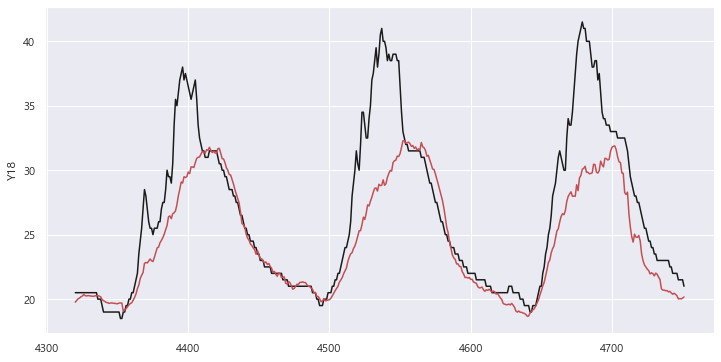

In [40]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x=train2_Y18.index, y=train2_Y18, ax=ax, c='k')
sns.lineplot(x=train2_Y18.index, y=single_train2_Y18_pred, ax=ax, c='r')

## 4. 모델 학습 및 검증
### Model Tuning & Evaluation
#### 1) Multi Model
- **Single Model는 day-night의 경계에서 급격하게 변동하는 모습을 보임**.
- **day night 기준을 더 복잡하게 smoothing하게 구성하여 각각 학습모델을 구축**
![모델설명_복수모델](./imgs/모델설명_복수모델.PNG)
- 따라서 여러 개의 day, night index에 대해 training을 한 후 이를 average 하는 방식을 통해 (일종의 soft voting ensemble) day-night 경계에서 보다 seamless 하도록 multi_model을 정의함.
![모델설명_복수모델](./imgs/모델설명_복수모델2.PNG)

## 한번 더 sub sub model - 세분화
![모델설명_이차복수모델2](./imgs/모델설명_이차복수모델.PNG)

![모델설명_이차복수모델2](./imgs/모델설명_이차복수모델2.PNG)

- **test set을 같이 학습시켜버렸고 찢었기 때문에 다른 test set 이 오면 다시 맞게 나눠서 테스트를 해야 한다..? 는 문제 발생 (108개 모델 각각이 test set 을 가지고 있는데, 새로운 test set이 오면 다시 분리하고 학습해야 되니까. 10분단위의 Task 문제에서 학습만 20분이 걸리는 이 작업은 비효율 적이다.**

In [41]:
# 
def multi_model(day_start, day_end, night_start, night_end, predict=True, **single_model_params):
    # day, night index의 grid. 총 ((day_end - day_start) / 2) * ((night_end - night_start) / 2) 개의 models.
    day_grid = np.meshgrid(np.arange(day_start, day_end, 2), np.arange(night_start, night_end, 2))[0].reshape(-1)
    night_grid = np.meshgrid(np.arange(day_start, day_end, 2), np.arange(night_start, night_end, 2))[1].reshape(-1)
    n_models = day_grid.shape[0]
    
    # Multiprocessing
    pool = ThreadPool(8)
    X_Y18_coefs_list = pool.map(lambda grid: single_model(day_night_index=grid, multi=True, **single_model_params), zip(day_grid, night_grid))
    
    # list에 저장된 multiprocessing의 결과(coefficients for each day, night combination)의 평균값을 구함.
    multi_X_Y18_coefs = pd.DataFrame(np.zeros((144, train1_X.shape[1])), index=np.arange(144), columns=train1_X.columns)
    multi_X_Y18_coefs['Ys_intercept'] = 0
    multi_X_Y18_coefs['Y18_intercept'] = 0
    for coefs in X_Y18_coefs_list:
        multi_X_Y18_coefs += coefs
    multi_X_Y18_coefs /= n_models
    
    # Predict Y18
    if predict:
        train2_Y18 = predict_Y18(train1_X, train2_X, multi_X_Y18_coefs)
        test_Y18 = predict_Y18(train1_X, test_X, multi_X_Y18_coefs)
        return train2_Y18, test_Y18, multi_X_Y18_coefs
    else:
        return multi_X_Y18_coefs

### 최종
- 97200여개의 세부적인 sub모델이 나옴. day, night 나누는 것 뿐만이 아닌 그 세부적으로 나눠진 각각들을. 그 모델들을 각각 훈련시킬수도 있지만,
- **나중에 실제로 활용 측면에서 계산하는 cost적인 측면도 고려**해야 되기 때문에,  
- 각 모델에서의 각 변수들에 대한 상관회귀계수를 구해서 df 로 만들어놓음.
- 최종적으로 새로운 test data가 왔을 때 곱만으로 계산 가능.

## Coefficient 계수를 기록해둠
![모델설명_계수접근](./imgs/모델설명_계수접근.PNG)
![모델설명_계수접근2](./imgs/모델설명_계수접근2.PNG)
![모델설명_계수접근3](./imgs/모델설명_계수접근3.PNG)
![모델설명_계수접근4](./imgs/모델설명_계수접근4.PNG)

#### => 전체를 다시 학습하지 않아도 시간대별로 더 상세해 질 것임

In [42]:
%%time
# day_start, day_ends, night_start, night_end 값은 리더보드 점수가 가장 높은 것으로 선택함.
train2_Y18_pred, test_Y18, multi_X_Y18_coefs = multi_model(day_start=21, day_end=45, night_start=91, night_end=109, predict=True,
                                                           train1_X=train1_X, train1_Ys=train1_Ys, train2_X=train2_X, train2_Y18=train2_Y18, test_X=test_X)

day_index : 21, night_index : 91day_index : 29, night_index : 91day_index : 37, night_index : 91

day_index : 21, night_index : 93

day_index : 29, night_index : 93day_index : 37, night_index : 93

day_index : 21, night_index : 95day_index : 29, night_index : 95

day_index : 31, night_index : 91
day_index : 39, night_index : 91
day_index : 23, night_index : 93
day_index : 31, night_index : 95
day_index : 23, night_index : 91
day_index : 31, night_index : 93
day_index : 39, night_index : 93
day_index : 23, night_index : 95
day_index : 41, night_index : 91
day_index : 33, night_index : 91
day_index : 25, night_index : 93
day_index : 25, night_index : 91
day_index : 33, night_index : 95
day_index : 33, night_index : 93
day_index : 41, night_index : 93
day_index : 25, night_index : 95
day_index : 43, night_index : 91
day_index : 35, night_index : 91
day_index : 27, night_index : 91
day_index : 43, night_index : 93
day_index : 27, night_index : 93
day_index : 35, night_index : 93
day_index 

In [43]:
# Training error
mean_squared_error(train2_Y18_pred, train2_Y18)

15.406505942738432

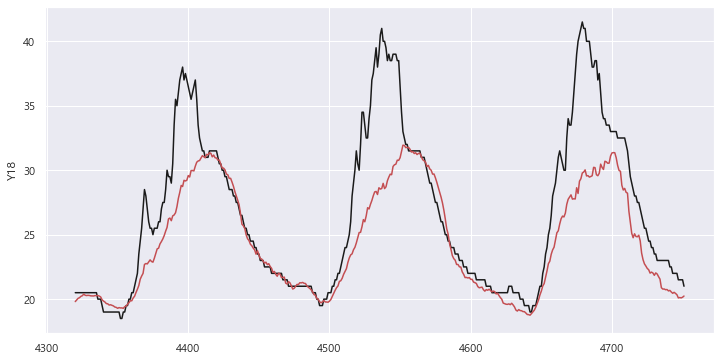

In [44]:
# Visualization : train2_Y18 prediction 
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x=train2_Y18.index, y=train2_Y18, ax=ax, c='k')
sns.lineplot(x=train2_Y18.index, y=train2_Y18_pred, ax=ax, c='r')

![결과](./imgs/결과.PNG)
#### => 3일은 아마 흐릿해서 그런 것 같다고 함

### 6. 결과 및 결언
#### Conclusion & Discussion

4752 7632
7632 10512


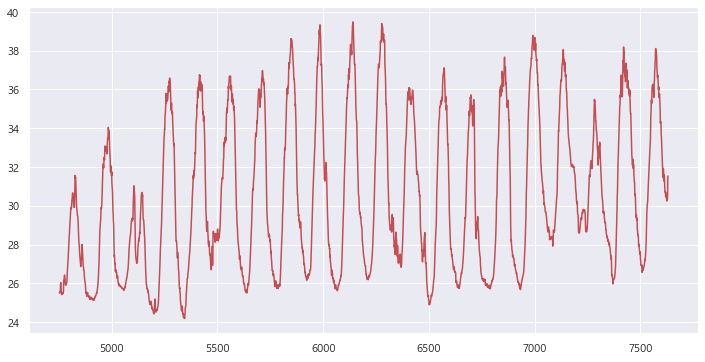

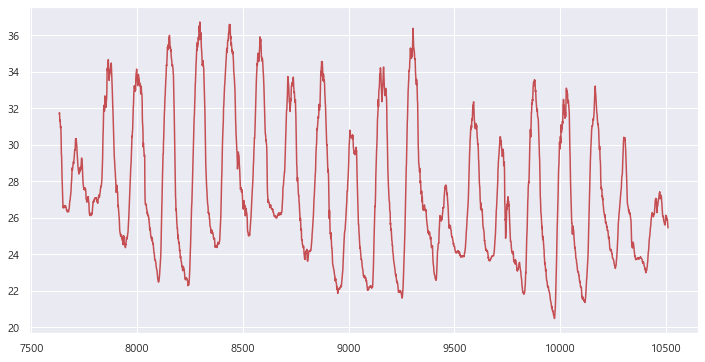

In [46]:
# Visualization : test_Y18 prediction
for idx in range(33, 73, 20):
    idx1, idx2 = 144*idx, 144*(idx+20)
    print(idx1, idx2)
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.lineplot(x=np.arange(idx1, idx2), y=test_Y18.loc[idx1:idx2-1], ax=ax, c='r')

In [ ]:
# Visualization : test_Y18 prediction
for idx in range(33, 113, 20):
    idx1, idx2 = 144*idx, 144*(idx+20)
    print(idx1, idx2)
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.lineplot(x=np.arange(idx1, idx2), y=test_Y18.loc[idx1:idx2-1], ax=ax, c='r')

In [ ]:
# Submission
submission = pd.DataFrame(index=test_X.index)
submission['Y18'] = test_Y18
submission.reset_index(inplace=True)
submission.to_csv('submission.csv', index=False)

- EDA에 시간 투자를 많이 해서 model을 다양하게 바꿔보는 시도를 해보지 못했습니다.

- 아무래도 training set의 크기가 작아 training score를 신뢰할 수 없다보니 public score에 의존할 수밖에 없었습니다.

- 그래서 가채점 점수는 1.02845인데 반해 최종 점수는 2.67974인 걸 보니 public test set에 overfit 하게 되었습니다.

- 본 모델을 실사용(예를 들어 target_X에 대해) 하기 위해서는 feature engineering을 한 후 multi_model()으로 얻은 multi_X_Y18_coefs를 활용해,

- target_Y18 = predict_Y18(train1_X, target_X, multi_X_Y18_coefs) 로 간단하게 얻을 수 있습니다.

#### 전체적인 problem - solution 측면으로 계속 해서 요런느낌도 심사위원들에게 어필하기 좋음